In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency, mode
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import catboost as cb
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

## Data preprocessing ###

In [49]:
DATA_PATH = "data/existing-customers.xlsx"
data = pd.read_excel(DATA_PATH)
print("\nColumns:", data.columns, "Row ID is unnecessary therefore it was decided to drop it.", sep="\n")
data = data.drop(columns=["RowID", "education-num"])

/Users/karol/.pyenv/versions/3.10.6/envs/DMenv/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")



Columns:
Index(['RowID', 'age', 'workclass', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'class'],
      dtype='object')
Row ID is unnecessary therefore it was decided to drop it.


### NA investigation

In [50]:
nas_count = data.isna().sum(axis = 0)
print("\nTable below represents number of NA values for each column.", nas_count,  sep="\n")


Table below represents number of NA values for each column.
age                  0
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
class                0
dtype: int64


As it is noticeable only three variables consist NAs. All of them are nominal therefore it was decided that during learning part use a Simple Imputer with most frequency strategy.

### Categorical Variables Analysis

As data consists both categorical and numerical variables it was decided to start with categorical ones. Firstly, I checked how many unique values has each variable. Afterwards, some barplots were plotted. They allowed to investigate the values frequencies for each variable.


Categorical variables: 
['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

Numerical variables: 
['age', 'capital_gain', 'capital_loss', 'hours_per_week']

Table representing number of unique attributes for each categorical variable: 
workclass          8
education         16
marital_status     7
occupation        14
relationship       6
race               5
sex                2
native_country    41
dtype: int64

To preprocess data correctly it was decided to take a closer look at each variable individually.


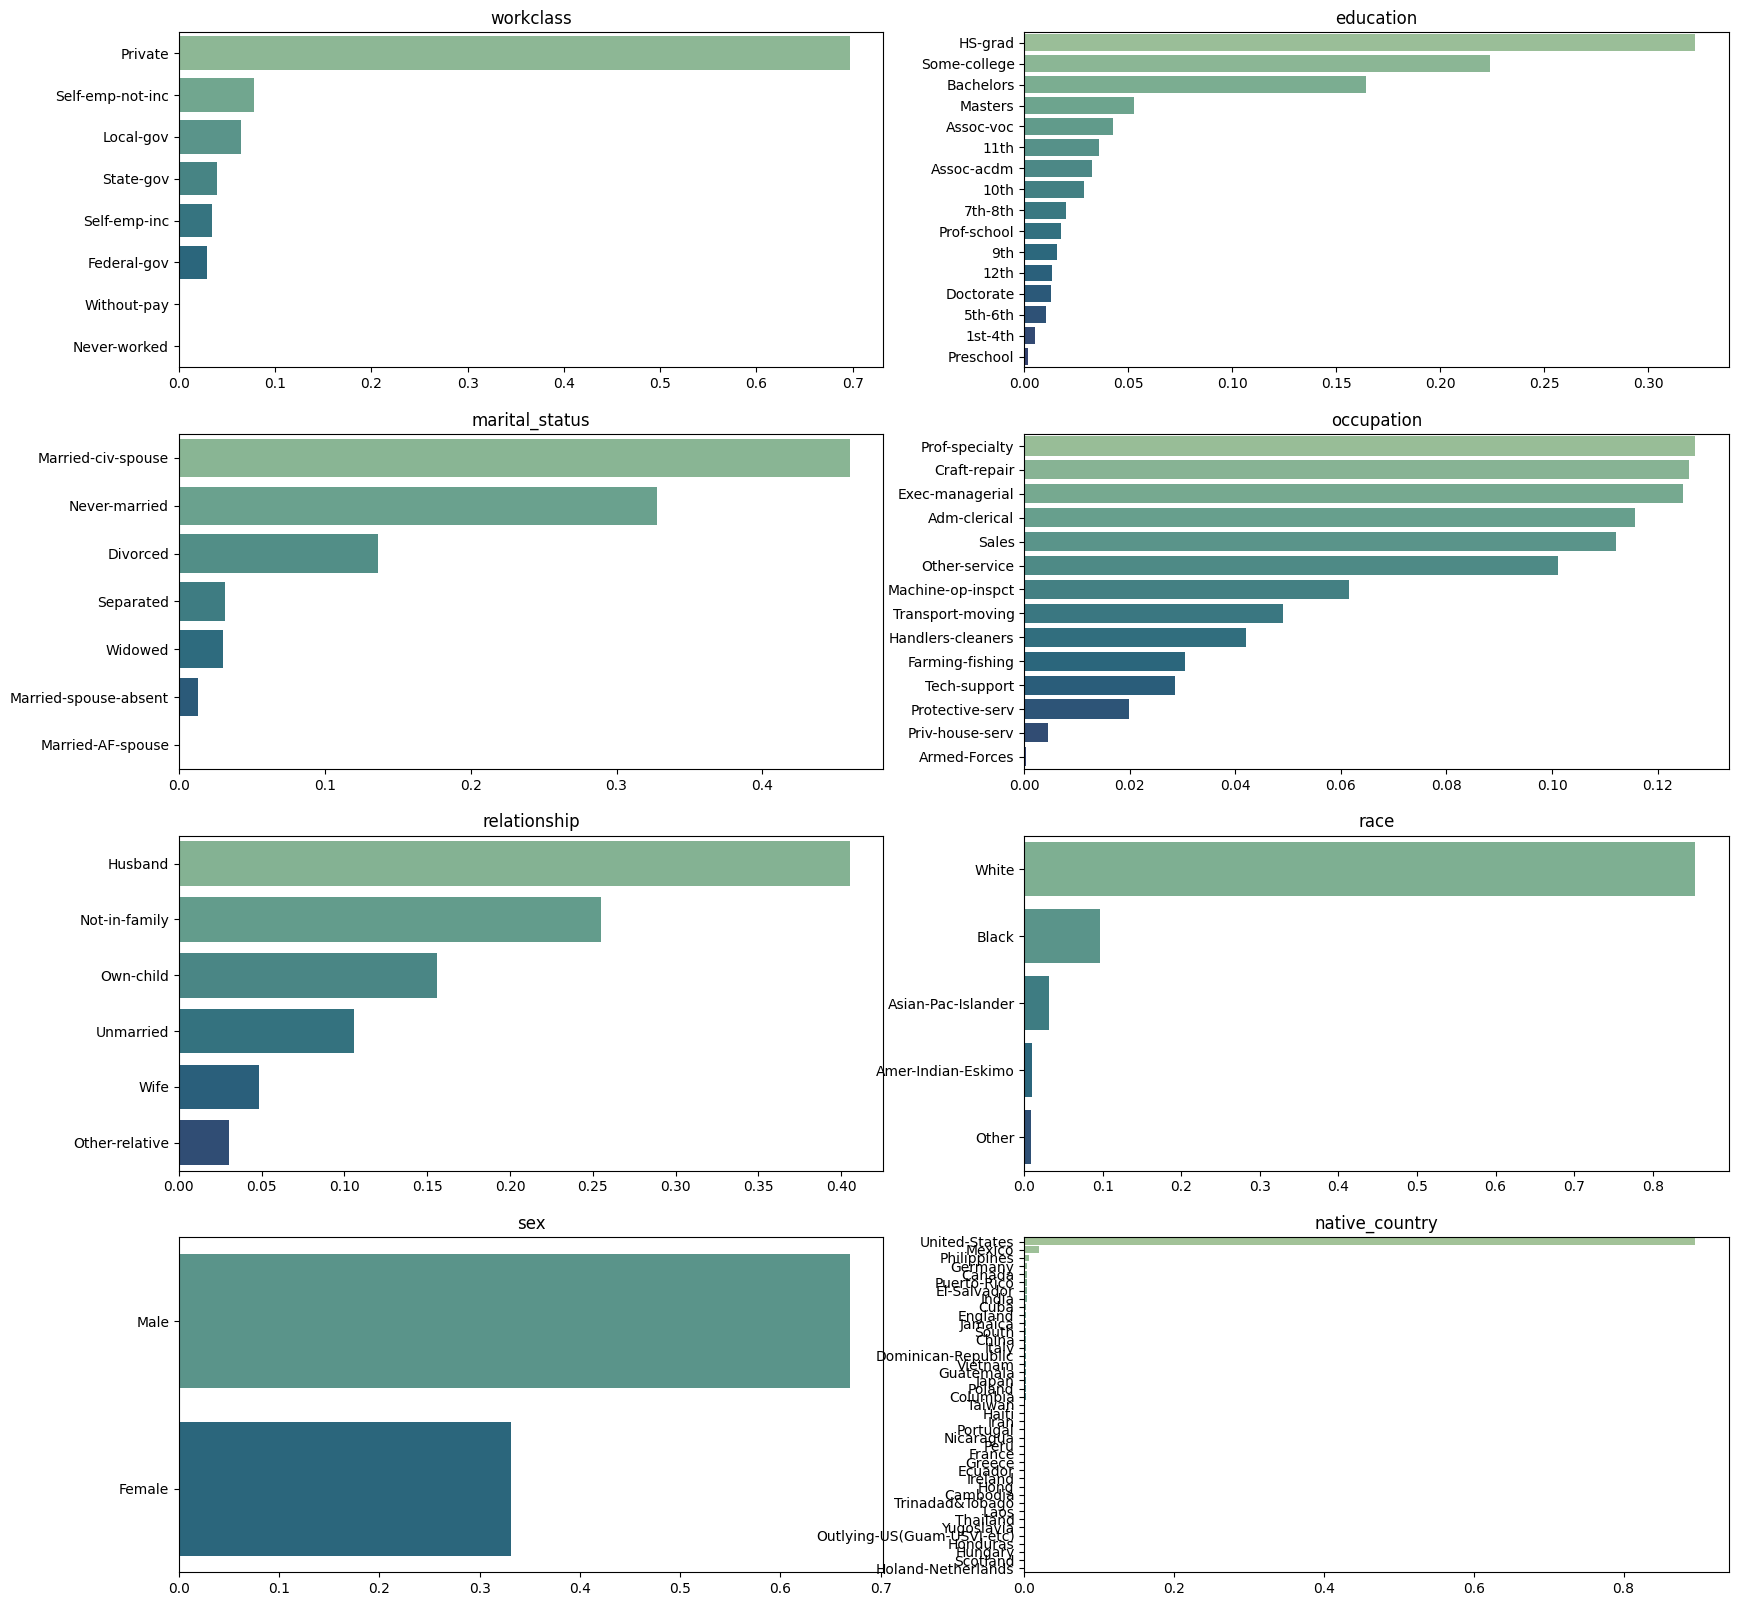

In [51]:
data.rename(columns = {'marital-status':'marital_status', 'native-country': 'native_country',
                            'capital-gain':'capital_gain', 'capital-loss': 'capital_loss', 'hours-per-week': "hours_per_week"}, inplace = True)

cat_cols = list(data.dtypes[data.dtypes=="object"].index)
num_cols = list(data.dtypes[data.dtypes=="int64"].index)
dep_var = "class"
cat_cols.remove("class")

print("\nCategorical variables: ", list(cat_cols), "\nNumerical variables: ", list(num_cols), sep="\n")

unique_table = data[cat_cols].nunique()
print("\nTable representing number of unique attributes for each categorical variable: ", unique_table, 
      "\nTo preprocess data correctly it was decided to take a closer look at each variable individually.", sep="\n")

fig_row = int(np.ceil(len(cat_cols)/2))
fig, ax = plt.subplots(fig_row,2, figsize=(20, 20))

indx = 0
for col in unique_table.index:
    freq_table = data[col].value_counts()/len(data[col])
    
    if indx%2 == 0:
        sns.barplot(ax=ax[int(indx/2),0], y=freq_table.index, x=freq_table.values, palette="crest")
        ax[int(indx/2),0].set_title(col)
    else:
        sns.barplot(ax=ax[int((indx-1)/2),1], y=freq_table.index, x=freq_table.values, palette="crest")
        ax[int((indx-1)/2),1].set_title(col)
    indx += 1
plt.show()


The figure above revealed that some variables aren't proportionally distributed. Especially, variables like native country, workclass, education and race. Therefore it was decided to focus on them in next steps as it was expected to do some data manipulation there.

#### Workclass

The table below represents the frequency distribution of the first variable, workclass. Its analysis would help us to determine what manipulation should be done to increase performance of our model.

In [52]:
freq_table = data["workclass"].value_counts()/len(data["workclass"])
print("Workclass", freq_table, sep="\n")


Workclass
Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: workclass, dtype: float64


We can notice that our data is slightly imbalanced as almost 70% of customers are private workclass. Now let's see how it is distributed if we take into account our dependent class.

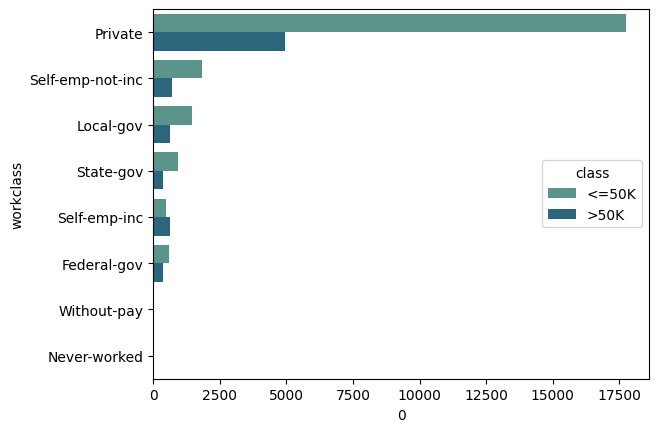

In [53]:
freq_table = data.loc[:,["workclass", "class"]].value_counts().reset_index()
sns.barplot(data = freq_table, y="workclass", x=0, hue="class", palette="crest")
plt.show()

We can notice that in most of groups classes are unevenly distributed. Moreover, as we previously noticed most of our data is represented by Private group which dominates our sample. Moreover, we have three small groups which represent different types of government workclass. Ultimately, I decided to merge them into one group. Additionally, groups Without Pay and Never Worked are not represantative as they constitue less than 0.001% of customers. At the beginning there was an idea to drop these observations, but after experimenting with them I decided to keep them as they might give some information about data.

In [54]:
# Group Merging
gov = ["Local-gov", "State-gov", "Federal-gov"]
data["workclass"] = data["workclass"].apply(lambda x: "Gov" if x in gov else x)

# # Dropping not representative observations
# indx = np.where((data["workclass"]=="Without-pay") | (data["workclass"]=="Never-worked"))
# data = data.drop(index=indx[0])

#### Education

Similar analysis was done for education variable.

In [55]:
freq_table = data["education"].value_counts()/len(data["education"])
print("Frequency Table: Education", freq_table, sep="\n")

Frequency Table: Education
HS-grad         0.322502
Some-college    0.223918
Bachelors       0.164461
Masters         0.052916
Assoc-voc       0.042443
11th            0.036086
Assoc-acdm      0.032769
10th            0.028654
7th-8th         0.019840
Prof-school     0.017690
9th             0.015786
12th            0.013298
Doctorate       0.012684
5th-6th         0.010227
1st-4th         0.005160
Preschool       0.001566
Name: education, dtype: float64


Based on the table above we can notice that education variable is more widely distributed. However, it also gives an impression that there are categories which practically represent similar level of education. But before we come up with any conclusions it was decided to take a closer look at the barplot.

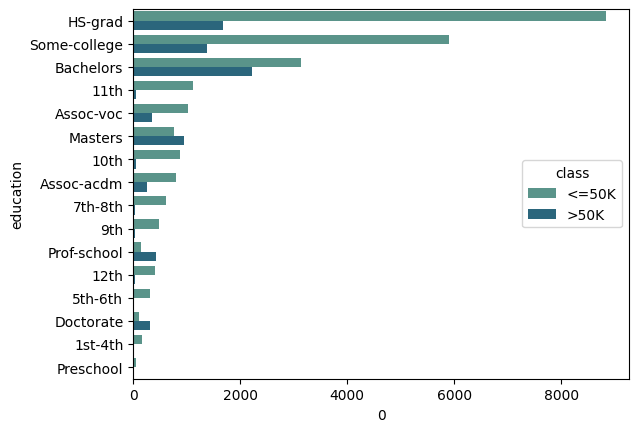

In [56]:
freq_table = data.loc[:,["education", "class"]].value_counts().reset_index()
sns.barplot(data = freq_table, y="education", x=0, hue="class", palette="crest")
plt.show()

The figure above confirmed our expectations. It is noticable that for all customers who had compulsory education, the class distribution is similar which confirmed thoughts above. Therefore, it was decided to group all education levels that are compulsory into one group. Secondly, it was noted that all Associates levels should be also also grouped together as the classes are also distributed similarly. There was also a thought of merging Bachelors and Some College together, but it was recognized that there is significant difference between attending to college and getting degree.

In [57]:
# Merging
compulsory = ["11th", "9th", "7th-8th", "5th-6th", "10th", "1st-4th", "12th", "Preschool"]
data["education"] = data["education"].apply(lambda x: "Compulsory" if x in compulsory else x)

assoc = ["Assoc-voc", "Assoc-acdm"]
data["education"] = data["education"].apply(lambda x: "Associate" if x in assoc else x)


#### Race

Frequency Table: Race
White                 0.854274
Black                 0.095943
Asian-Pac-Islander    0.031909
Amer-Indian-Eskimo    0.009551
Other                 0.008323
Name: race, dtype: float64


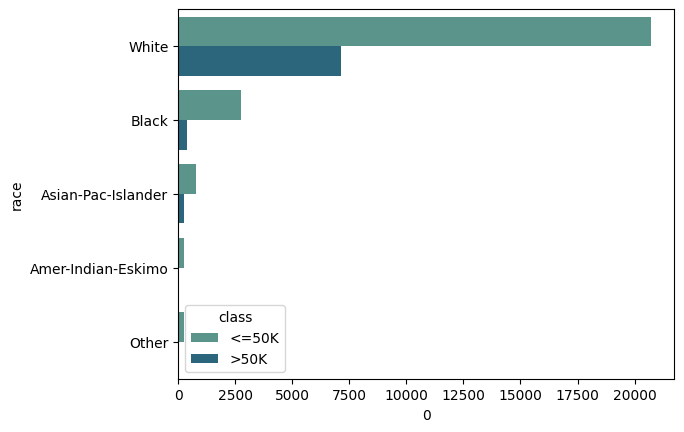

In [58]:
freq_table = data["race"].value_counts()/len(data["race"])
print("Frequency Table: Race", freq_table, sep="\n")
freq_table = data.loc[:,["race", "class"]].value_counts().reset_index()
sns.barplot(data = freq_table, y="race", x=0, hue="class", palette="crest")
plt.show()

From the table above we can notice that our data is dominated by White customers. However, if we look at the bar plot we can notice that the difference of the earnings distribution is not as significant. Therefore, it is expected that this variable would not have any strong impact in our model. Ultimately, it was decided to group all other races than White into one group.

In [59]:
race = ["Black", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other"]
data["race"] = data["race"].apply(lambda x: "Other" if x in race else x)

#### Native Country

In [60]:
freq_table = data["native_country"].value_counts()/len(data["native_country"])
print("Frequency Table: Native Country", freq_table, sep="\n")

Frequency Table: Native Country
United-States                 0.895857
Mexico                        0.019748
Philippines                   0.006081
Germany                       0.004207
Canada                        0.003716
Puerto-Rico                   0.003501
El-Salvador                   0.003255
India                         0.003071
Cuba                          0.002918
England                       0.002764
Jamaica                       0.002488
South                         0.002457
China                         0.002303
Italy                         0.002242
Dominican-Republic            0.002150
Vietnam                       0.002058
Guatemala                     0.001966
Japan                         0.001904
Poland                        0.001843
Columbia                      0.001812
Taiwan                        0.001566
Haiti                         0.001351
Iran                          0.001321
Portugal                      0.001136
Nicaragua                     0.

Just by looking at the table we can notice that data is strongly imbalanced. Most of our customers are Americans. It means that data is practically homogenous and any useful information could not be taken from this variable. Therefore, it was decided to drop it.

In [61]:
data = data.drop(columns=["native_country"])
cat_cols.remove("native_country")

### Numerical Variables

To analyze numerical variables it was decided to plot density distributions for each class. Based on them further investigations could be done.


Basic statistics for numerical variables:
                age  capital_gain  capital_loss  hours_per_week
count  32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647   1077.648844     87.303830       40.437456
std       13.640433   7385.292085    402.960219       12.347429
min       17.000000      0.000000      0.000000        1.000000
25%       28.000000      0.000000      0.000000       40.000000
50%       37.000000      0.000000      0.000000       40.000000
75%       48.000000      0.000000      0.000000       45.000000
max       90.000000  99999.000000   4356.000000       99.000000


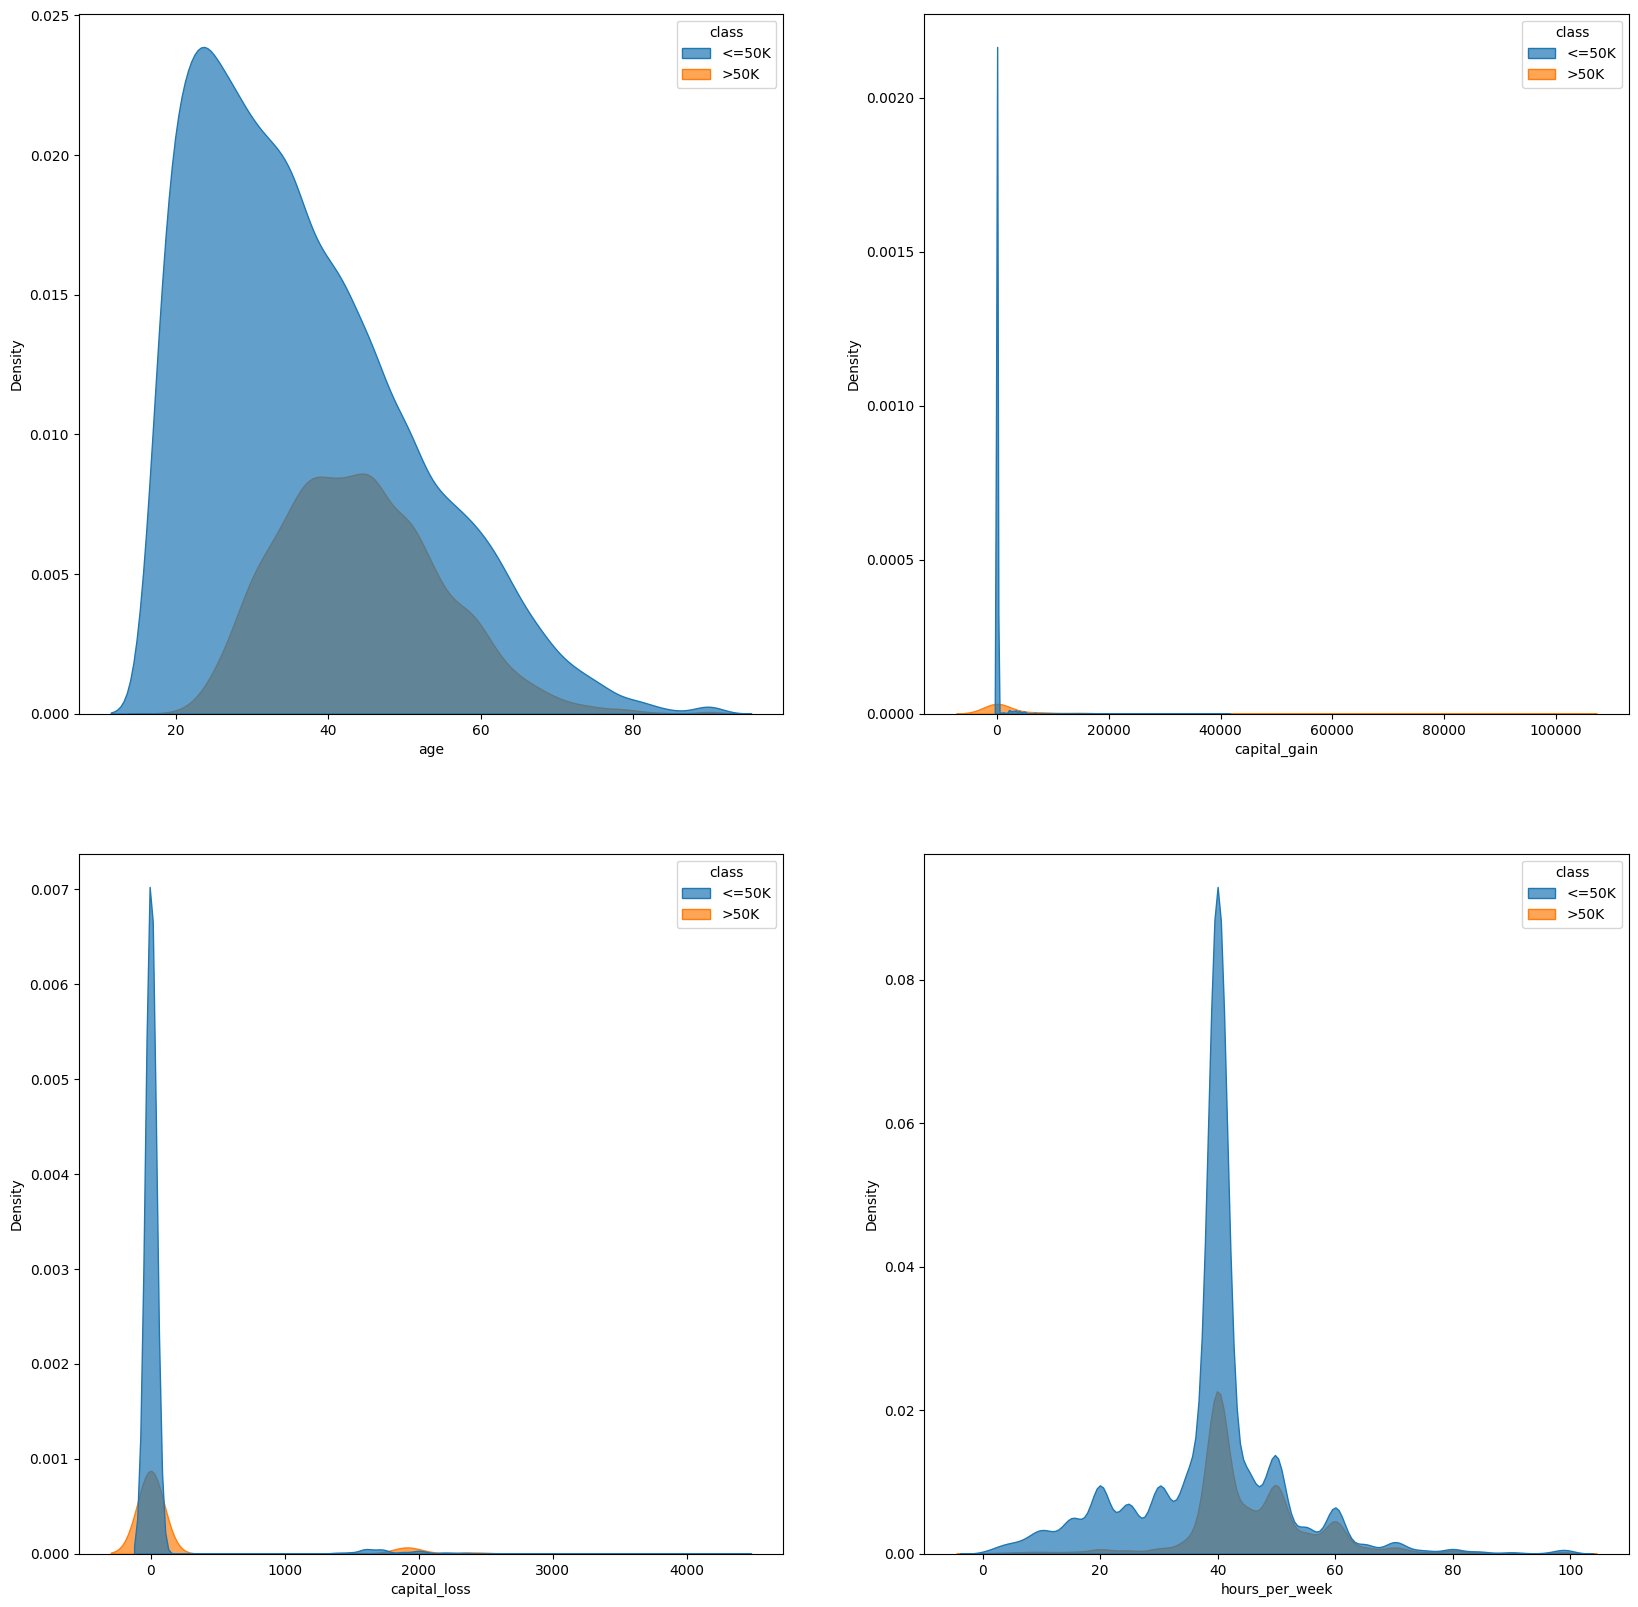

In [62]:
num_dscrb = data[num_cols].describe()
print("\nBasic statistics for numerical variables:", num_dscrb, sep="\n")

fig_row = int(np.ceil(len(num_cols)/2))
fig, ax = plt.subplots(fig_row,2, figsize=(20,20))
indx = 0
for col in num_cols:
    rgb = (np.random.random(), np.random.random(), np.random.random())
    if indx%2 == 0:
        sns.kdeplot(ax=ax[int(indx/2),0], data = data, x=col, hue="class", fill=True, color=rgb, alpha=.7)
        # ax[int(indx/2),0].set_title(col)
    else:
        sns.kdeplot(ax=ax[int((indx-1)/2),1], data = data, x=col, hue="class", fill=True, color=rgb, alpha=.7)
        # ax[int((indx-1)/2),1].set_title(col)
    indx += 1
plt.show()

Based on the statistics and plots we can notice that there are some outliers which would be investigated later. Secondly, we can notice that the distributions for each variable slightly depends on the class. Therefor, they might be helpful in our model.

#### Outliers analysis

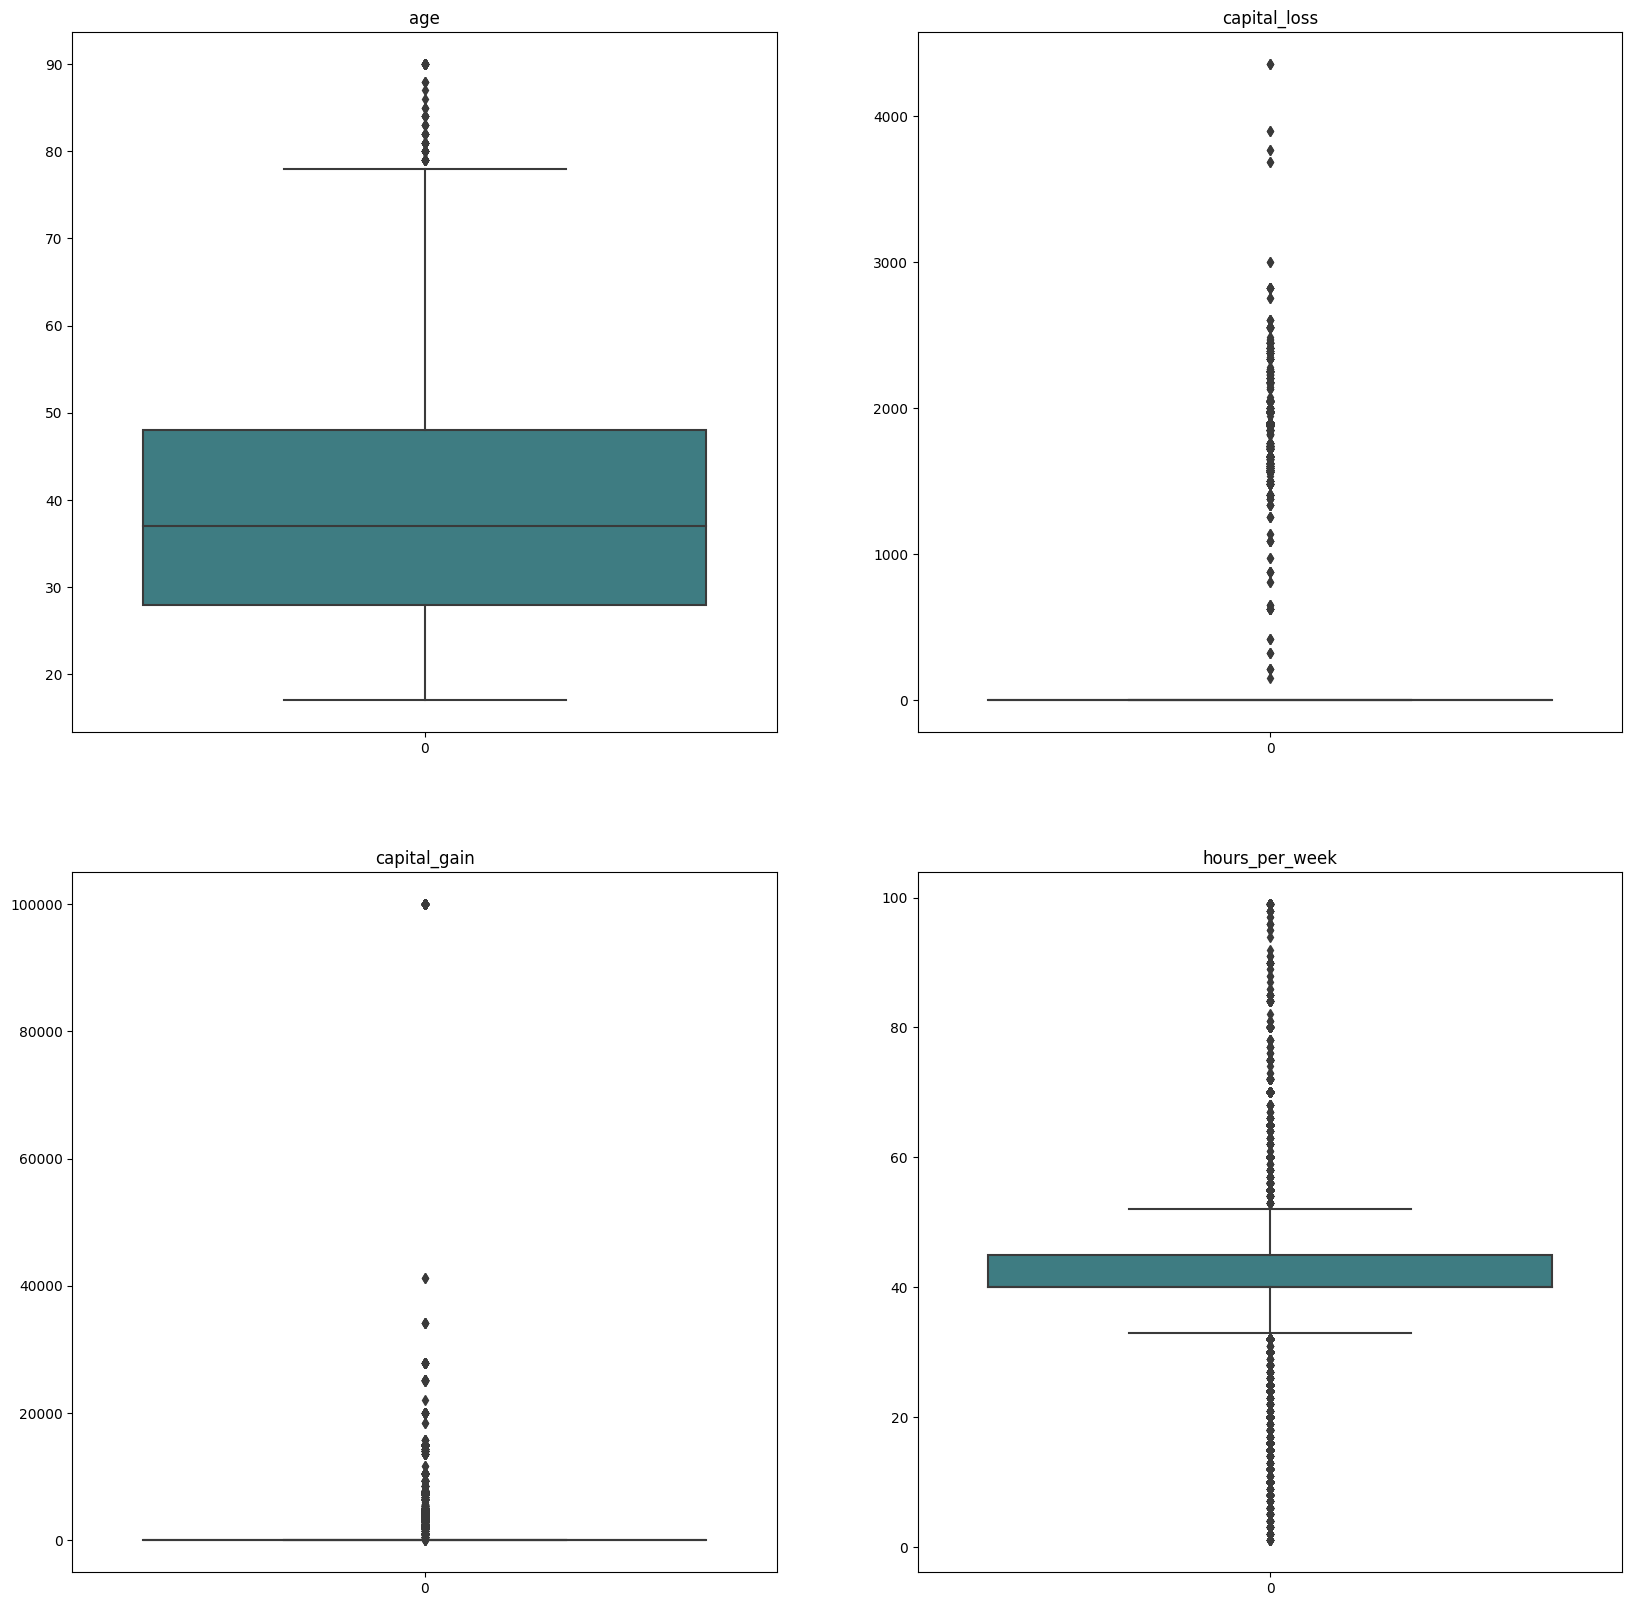

In [63]:
fig_col = int(np.ceil(len(num_cols)/2))
fig, ax = plt.subplots(2, fig_col, figsize=(20,20))
indx = 0
for col in num_cols:
    rgb = (np.random.random(), np.random.random(), np.random.random())
    if indx%2 == 0:
        sns.boxplot(ax=ax[0,int(indx/2)], data = data[col], palette="crest", color=rgb)
        ax[0,int(indx/2)].set_title(col)
    else:
        sns.boxplot(ax=ax[1, int((indx-1)/2)], data = data[col], palette="crest", color=rgb)
        ax[1, int((indx-1)/2)].set_title(col)
    indx += 1
plt.show()

Based on the figure above we can notice that all variables consist number of outliers. They might have a significant impact on the model efficiency.
Firstly, it was noticed that for variables capital gains and capital losses all observations that have different values than zero are outliers. 
It is clearly visible on the box plot where the whole box actually is a straigh line around zero. 
Moreover, there is also a strange gap between some customers capital gains. There is a significant group of customers who gained exactly 99,999 euro which is not surrounded by any neighbours. 
Therefore, it was believed that these inputs might be errors. 

Based on these observations there was an idea to create new dataset which discretize capital loss and capital gain. However, further experiments revealed that badly impacts prediction capabilities. Ultimately, it was decided only to drop customers who gained 99,999 euro.

In [64]:
# Drop observations
indx = np.where(data["capital_gain"]==99999)
data = data.drop(index=indx[0])

# def discretize(x):
#     if x>0:
#         return "True"
#     else:
#         return "False"
    
# data["capital_gain"] = data["capital_gain"].apply(discretize)
# num_cols.remove("capital_gain")
# data["capital_loss"] = data["capital_loss"].apply(discretize)
# num_cols.remove("capital_loss")

### Relationships between variables

#### Correlation

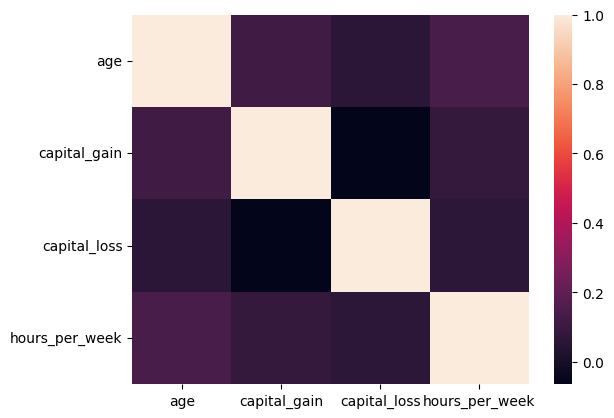

In [65]:
corr = data[num_cols].corr(method="spearman")
sns.heatmap(corr)
plt.show()

As we can see the correlation is really low, therefore there is no strong relationship between numerical variables.

#### Cramer's V

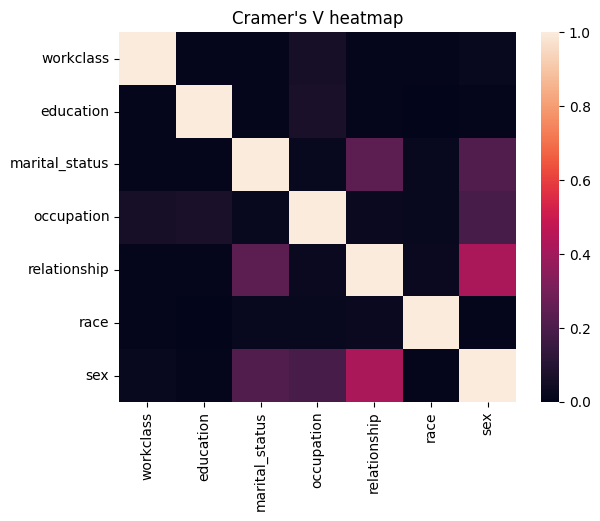

In [66]:
def cramers_V(var1,var2):
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

cramer_matrix = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), index=cat_cols, columns=cat_cols)
cat_memory = cat_cols.copy()
for row in cat_cols:
    for col in cat_memory:
        cramer_matrix.loc[row, col] = np.round(cramers_V(data[row], data[col]), 2)
        cramer_matrix.loc[col, row] = cramer_matrix.loc[row, col]
    cat_memory.remove(row)

sns.heatmap(cramer_matrix)
plt.title("Cramer's V heatmap")
plt.show()

There, was a slight expectation on my side that there might be relationship between variables, marital-status and relationship. However, on the heatmap we can notice that it is very weak. The strongest one is between relationship and sex. However, it is also not as siginificant. In short, the conclusion is clear. We don't have any variables with strong relationships.

## Statistical analysis with depending variable

### ANOVA analysis for numerical variables

In [67]:
anova_table = pd.DataFrame(np.zeros((1, len(num_cols))), 
                           ["label"], num_cols)

for num in num_cols:
    CategoryGroupLists = data.groupby("class")[num].apply(list)
    anova_results = f_oneway(*CategoryGroupLists)
    anova_table.loc["label", num] = np.round(anova_results.pvalue, 2)

print("\nTable below represents anova analysis between categorical and numerical variables:", anova_table, sep="\n\n")


Table below represents anova analysis between categorical and numerical variables:

       age  capital_gain  capital_loss  hours_per_week
label  0.0           0.0           0.0             0.0


As we can notice that for all numeric variables p-values are close to zero.
Therefore, we can state that all of them might play crucial factor in predicting labels.

#### Chi-square analysis for categorical variables

In [68]:
chi2_table = pd.DataFrame(np.zeros((len(cat_cols), 1)), 
                            cat_cols, ["label"])
for col in cat_cols:
    crosstab = np.array(pd.crosstab(data[col],data["class"], rownames=None, colnames=None)) # Cross table building
    result = chi2_contingency(crosstab)
    chi2_table["label"][col] = result[1]

print("\nChi2 table", chi2_table, sep="\n")




Chi2 table
                        label
workclass       8.968457e-156
education        0.000000e+00
marital_status   0.000000e+00
occupation       0.000000e+00
relationship     0.000000e+00
race             3.184270e-53
sex              0.000000e+00


Based on the table we can conclude that all categorical variables are related to our dependent variable, as for each variable the p-value is close to 0.

### Distribution of dependent variable

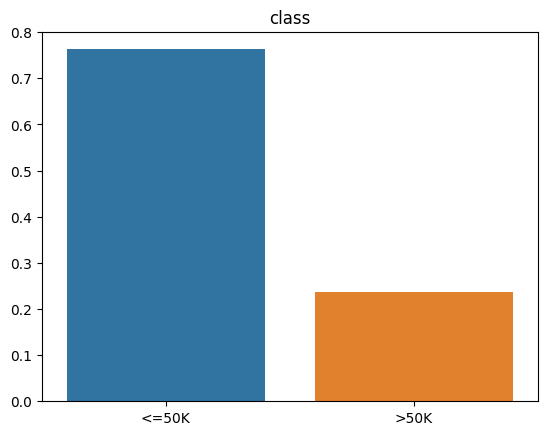

In [69]:
def discretize_func(x):
    if x == "<=50K":
        return 0 
    elif x == ">50K":
        return 1
    else:
        return x
        
data[dep_var] = data[dep_var].apply(discretize_func)
labels, counts = np.unique(data[dep_var], return_counts=True)
sns.barplot(y=counts/len(data), x=["<=50K", ">50K"])
plt.title(dep_var)
plt.show()

As we can see our depending variable is slightly imbalanced. Therefore, it was decided to use upsampling method in next steps to obtain more reliable results.

# Modelling

## Splitting Data

The first step was to divide data into training and testing data. The "train_test_split" method from sklearn was used.

In [70]:
ind_var = list(data.columns)
ind_var.remove("class")

train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=10)
X_train, X_test = train[ind_var], test[ind_var]
y_train, y_test = train["class"], test["class"]

## Upsampling

The problem with imbalanced data is that model by assigning "<=50" label for every observation will obtain still very high accuracy. There are two sollutions for that problem, downsampling and upsampling. The first one randomly cuts observations which belongs to the bigger class. However, upsampling is a procedure which synthetically generates data points for smaller class. Ultimately, it was decided to go on with upsampling method as we do not loose information from our dataset. The SMOTE was the chosen algorithm.

## Preprocessing

The first step was to preprocess data. To do that the ColumnTransformer was created. It consists preprocessing pipeline for categorical and numerical variables. For categorical ones the SimpleImputer with most frequent strategy was used. And to encode them the OneHotEncoder was used. However, numeric variables were scaled using StandardScaler.

In [71]:
unencodeded_categoric = list(X_train.dtypes[X_train.dtypes=="object"].index)
numeric = num_cols

numeric_transformer = imbpipeline(steps=[("scaler", StandardScaler())])
categoric_transformer = imbpipeline(steps=[
                                        ("imputer", SimpleImputer(strategy="most_frequent")),
                                        ("encoder", OneHotEncoder())
                                        ])

preprocessor = ColumnTransformer(transformers=[
                                            ("num_preprocessing", numeric_transformer, numeric),
                                            ("cat_preprocessing", categoric_transformer, unencodeded_categoric)
                                ])

## Classifier Selection

In this project it was decided to compare five different algorithms and choose the best one for prediction. The following classifiers were taken into account:
- K-Neighbors
- Decision Tree
- AdaBoost
- Random Forest
- Catboost

The first two algorithms are rather simple ones and it was expected that they won't perform as well as the rest ones. However, I hoped that they would give some intuition regarding the data. 

All of these algorithms require a proper tunning. Therefore, a GridSearchCV method from sklearn was used. But before going into details about parameters used during grid search let's talk a little bit about models' parameters.

##### K-Neighbors
For KNN method there were three different parameters which required tunning. The first one was n_neighbors. Here, it was decided to look at the range of odd numbers between 7 and 11. The second parameter was weights which has two different selection options, uniform and distance. The difference between these two is that uniform treats all neighbors equally, however distance assigns weights to neighbors by the inverse of their distance. The last one was metric. Here we have many selection options, however, it was decided to go on with euclidean/minkowski and cosine. Moreover, it was expected that cosine would be better as we have a lot of categorical data and by using OneHotEncoder the dimension has increased significantly.

##### Decision Tree
For Decision Tree model there are plenty of parameters to take into account. Firstly, I was focused on criterion. It is responsible to measure the quality of the split. The selection was between Gini and Entropy. Moreover, based on theory we know that this algorithm tends to overfit as it grows. However, it includes some stopping criterias which aim to reduce that problem. These are max_depth, min_samples_split, min_samples_leaf and max_features. To visualize this issue it was decided to create a validation set and plot AUC scores which compares validation and training sets. The resulting figure was printed below. By looking at the first plot it can be concluded that while max_depth is around 10 the AUC scores between training and validation sets starts to diverge. Therefore, it was decided to include it in searching parameters. 

##### AdaBoost
AdaBoost is an example of Boosting algorithm. Here, there were only two parameters taken into account. The first one was n_estimators which represent the maximum number of estimators at which boosting is terminated. It was decided to choose from the list of [10, 50, 100, 500, 1000, 5000].
The other parameter was the learning rate which is applied to classifier at each boosting iteration. There is also parameter called estimator from which the boosted ensemble is built. It was decided to go on with deafult one which is decision tree with one split.

##### Random Forest
The aim of Random Forest is to fits number of decision tree classifiers on different data sub-samples. It uses averaging to improve the predictive accuracy and control over-fitting. Here we we have two parameters to tune. One of which is the criterion which is the same as in case of Decision Tree algorithm. The second one is n_estimators which consist number of trees in forest.

##### CatBoost
CatBoost is an algorithm for gradient boosting on decision trees. There are different parameters. The first one determines the bootstrap type. The chosen selection was Bayesian and MVS. The second parameter was the l2_leaf_reg which is a coefficient at the L2 regularization for the cost function. The next one was learning rate. Based on the different applications it was decided to go on with rather low numbers. There is also a depth parameter which constitutes depth of the trees. 

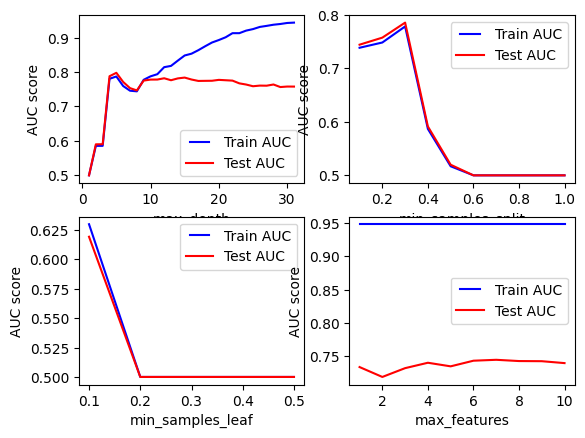

In [72]:
models = {"knn": KNeighborsClassifier(),
        "tree": DecisionTreeClassifier(random_state=2023),
        "ada": AdaBoostClassifier(random_state=2023),
        "random_forest": RandomForestClassifier(random_state=2023)}

params = {"knn": {"classifier__n_neighbors": [11,13,15],
                "classifier__weights": ["uniform", "distance"],
                "classifier__metric": ["minkowski", "cosine"]},
                
        "tree": {"classifier__criterion": ["gini", "entropy"],
                "classifier__max_depth": [6, 7, 8, 9, 10]},

        "ada": {"classifier__n_estimators": [10, 50, 100, 500, 1000, 5000],
                "classifier__learning_rate": [0.5, 0.75, 1]},

        "random_forest": {"classifier__n_estimators": [50, 100, 500],
                        "classifier__criterion": ["gini", "entropy"]}}
                        

def plot_tree_results(param_type, elements, ax):
    train_results = []
    test_results = []


    for element in elements:
        d = {param_type: element}
        dt = Pipeline(steps=[
                        ("preprocessing", preprocessor),
                        ("classifier", DecisionTreeClassifier(**d))], 
                verbose=False)
        dt.fit(X_train, y_train)
        train_pred = dt.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous train results
        train_results.append(roc_auc)
        y_pred = dt.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous test results
        test_results.append(roc_auc)

    line1, = ax.plot(elements, train_results, "b", label="Train AUC")
    line2, = ax.plot(elements, test_results, "r", label="Test AUC")
    ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    ax.set_ylabel("AUC score")
    ax.set_xlabel(param_type)

fig, ax = plt.subplots(2,2)
elements = range(1,32)
plot_tree_results("max_depth", elements, ax[0,0])

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
initial_parameters = {"max_depth": 10}
plot_tree_results("min_samples_split", min_samples_splits, ax[0,1])

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
plot_tree_results("min_samples_leaf", min_samples_leafs, ax[1,0])

max_features = list(range(1, X_train.shape[1]))
plot_tree_results("max_features", max_features, ax[1,1])
plt.show()




To find optimal parameters for each model the GridSearchCV method was used. The roc auc metric was used as a scoring metric and three folds have been used. Also, the pipeline from imblearn library was used where following steps have been included, preprocessing, oversampling and classifying. 

In [27]:
results = {}
for model in models.keys():
    print("\nGrid search for {}".format(model))
    pipe = imbpipeline(steps=[
                        ("preprocessing", preprocessor),
                        ('smote', SMOTE(random_state=2023)),
                        ("classifier", models[model])])

    random_search = GridSearchCV(estimator=pipe, 
                                param_grid=params[model],                                
                                refit=True, scoring="roc_auc", cv=3,
                                verbose=0, return_train_score=True)

    random_search.fit(X_train, y_train)
    print("ROC_AUC results: ", random_search.best_score_, "\nBest parameters:", "\n", random_search.best_params_)



Grid search for knn
ROC_AUC results:  0.8889076087467466 
Best parameters: 
 {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 15, 'classifier__weights': 'uniform'}

Grid search for tree
ROC_AUC results:  0.8900983937894562 
Best parameters: 
 {'classifier__criterion': 'entropy', 'classifier__max_depth': 8}

Grid search for ada
ROC_AUC results:  0.9216054889759202 
Best parameters: 
 {'classifier__learning_rate': 1, 'classifier__n_estimators': 5000}

Grid search for random_forest
ROC_AUC results:  0.884193286041417 
Best parameters: 
 {'classifier__criterion': 'entropy', 'classifier__n_estimators': 500}


For CatBoost algorithm it was reccomended to use methods from its own library. Therefore, I needed to analyze it seperately. Firstly, it was decided to deal with NAs manually. Then, using transformed independent data and dependent one, the catboost.Pool object was created where all categorical variables were determined, so algorithm could deal with them without using OneHotEncoder. Moreover, to deal with imbalanced data instead of using SMOTE algorithm the scale_pos_weight parameter has been set to 3. 

In [79]:
nas_count = X_train.isna().sum(axis = 0)
X_train_cat = X_train.copy()
for indx in nas_count[nas_count>0].index:
    md = mode(X_train_cat[indx])
    X_train_cat[indx] = X_train_cat[indx].fillna(md.mode[0])

nas_count = X_test.isna().sum(axis = 0)
X_test_cat = X_test.copy()
for indx in nas_count[nas_count>0].index:
    md = mode(X_test_cat[indx])
    X_test_cat[indx] = X_test_cat[indx].fillna(md.mode[0])

grid = {'bootstrap_type': ["Bayesian","MVS"], 
            'depth':[5, 7],
            'learning_rate':[0.1, 0.15],
            'l2_leaf_reg':[2, 3],
            'border_count':[5, 10],
            'bagging_temperature':[0.25, 0.75],
            'random_strength':[0.2, 0.8],
            'max_ctr_complexity':[3, 5]}


train_dataset = Pool(X_train_cat, y_train, cat_features=unencodeded_categoric)
test_dataset = Pool(X_test_cat, y_test, cat_features=unencodeded_categoric)

model = CatBoostClassifier(random_state=2023, iterations=100, eval_metric='AUC', scale_pos_weight=3)
result = model.grid_search(grid,train_dataset, plot=True, cv=3, partition_random_seed=2023)

/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_25850/4058354356.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  md = mode(X_train_cat[indx])
/Users/karol/.pyenv/versions/3.10.6/envs/DMenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_25850/4058354356.py:4: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pan

## Comparison of models

After selecting optimal parameters there was time for comparison part. Using best models for each algorithm the mean cross validation score was calculated. There are three different results taken into account, accuracy, roc_auc score and f1 score. Based on them the final algorithm was selected which will be more developed in next sections.

In [85]:
f = open('data/search_grid_results.pkl', 'rb')
best_models = pickle.load(f)
f.close()

In [48]:
eval_table = pd.DataFrame(np.zeros((3, len(best_models.keys()))), index=["Accuracy", "ROC_AUC", "F1-score"], columns=best_models.keys())

for key in models.key():
    if key=="catboost":
        params = {"random_state": 2023, "iterations": 100, "eval_metric": 'Accuracy',  "loss_function": "Logloss", "scale_pos_weight": 3,}
        params.update(best_models["catboost"])
        
        scores = cb.cv(train_dataset,params, fold_count=3, verbose=False)
        eval_table.loc["Accuracy", key] = np.mean(scores["test-Accuracy-mean"])
        
        params["eval_metric"] = "AUC"
        scores = cb.cv(train_dataset,params, fold_count=2, plot="True", verbose=False)
        eval_table.loc["ROC_AUC", key] = np.mean(scores["test-AUC-mean"])
        
        params["eval_metric"] = "F1"
        scores = cb.cv(train_dataset,params, fold_count=2, verbose=False)
        eval_table.loc["F1-score", key] = np.mean(scores["test-F1-mean"])
    else:
        pipe = imbpipeline(steps=[
                        ("preprocessing", preprocessor),
                        ('smote', SMOTE(random_state=2023)),
                        ("classifier", models[key].set_params(**best_models[key]))])
        
        eval_table.loc["Accuracy", key] = np.mean(cross_val_score(pipe, X_train, y_train, scoring="accuracy", cv=3))
        eval_table.loc["ROC_AUC", key] = np.mean(cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=3))
        eval_table.loc["F1-score", key] = np.mean(cross_val_score(pipe, X_train, y_train, scoring="f1", cv=3))

eval_table

Training on fold [0/3]

bestTest = 0.832379459
bestIteration = 85

Training on fold [1/3]

bestTest = 0.8319479297
bestIteration = 87

Training on fold [2/3]

bestTest = 0.8356336261
bestIteration = 98



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.9143569402
bestIteration = 91

Training on fold [1/2]

bestTest = 0.9160982861
bestIteration = 99

Training on fold [0/2]

bestTest = 0.8300395257
bestIteration = 74

Training on fold [1/2]

bestTest = 0.8314226848
bestIteration = 58



,knn,tree,ada,random_forest,catboost
Accuracy,0.788743,0.788858,0.859458,0.834304,0.829684
ROC_AUC,0.888908,0.890098,0.921605,0.884193,0.912568
F1-score,0.655684,0.657128,0.712332,0.657926,0.827620


Based on the results we can notice that boosting algorithms received the highest scores as it was expected. But surprisingly the KNN and DecisiionTree algorithms were very close to these advanced ones. Ultimately, the CatBoost has been selected as it had similar Accuracy and ROC_AUC scores as AdaBoost but had better F1 statistic in comparison to others. Therefore, the fitting method where testing dataset was used as an eval_set.

## Calibration

Usually, models that try to predict binary probabilities tend to assign extreme probabilities, close to 1 or 0, for each observation. It means that they are not well distributed. This issue doesn't apply to probabilistic models. However, to solve it in other models the calibration is required. Therefore it was decided to use the CalibratedClassifierCV class from sklearn library with our CatBoost classifier. For comparison purposes the calibration plot was created below. We can notice that uncalibrated CatBoost was behaving relatively well, however after calibration it was very close to perfectly calibrated models.

0:	test: 0.8918945	best: 0.8918945 (0)	total: 10.1ms	remaining: 997ms
1:	test: 0.8950606	best: 0.8950606 (1)	total: 19.4ms	remaining: 949ms
2:	test: 0.8965096	best: 0.8965096 (2)	total: 27.6ms	remaining: 891ms
3:	test: 0.8982898	best: 0.8982898 (3)	total: 35.3ms	remaining: 848ms
4:	test: 0.8992592	best: 0.8992592 (4)	total: 43.4ms	remaining: 824ms
5:	test: 0.9028370	best: 0.9028370 (5)	total: 50.7ms	remaining: 794ms
6:	test: 0.9043928	best: 0.9043928 (6)	total: 58.4ms	remaining: 776ms
7:	test: 0.9056716	best: 0.9056716 (7)	total: 66.3ms	remaining: 763ms
8:	test: 0.9069790	best: 0.9069790 (8)	total: 74.9ms	remaining: 758ms
9:	test: 0.9073855	best: 0.9073855 (9)	total: 82.7ms	remaining: 744ms
10:	test: 0.9071788	best: 0.9073855 (9)	total: 90.8ms	remaining: 735ms
11:	test: 0.9077101	best: 0.9077101 (11)	total: 98ms	remaining: 719ms
12:	test: 0.9081452	best: 0.9081452 (12)	total: 106ms	remaining: 711ms
13:	test: 0.9085845	best: 0.9085845 (13)	total: 114ms	remaining: 699ms
14:	test: 0.90891

/Users/karol/.pyenv/versions/3.10.6/envs/DMenv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/karol/.pyenv/versions/3.10.6/envs/DMenv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]


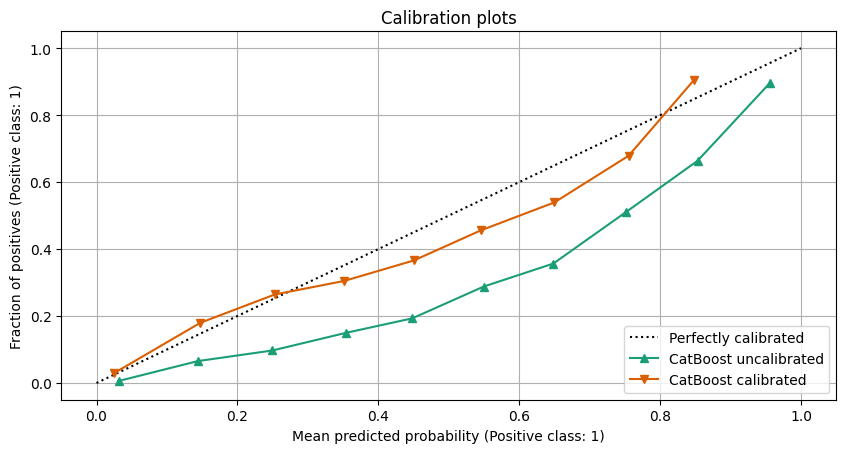

In [50]:
classifier = CatBoostClassifier(**params)
classifier.fit(X_train_cat, y_train, eval_set=test_dataset, cat_features=unencodeded_categoric)
model_cal = CalibratedClassifierCV(estimator=classifier,cv='prefit')
model_cal.fit(X_train_cat,y_train)

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v"]

clf_list = [
    (classifier, "CatBoost uncalibrated"),
    (model_cal, "CatBoost calibrated")
]

for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_cat,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
plt.show()

# Profit Estimations

In this part of the project the estimations for potential customers were predicted. But before it was necessary to preprocess data.

In [51]:
FINAL_DATA_PATH = "data/potential-customers.xlsx"
final_data = pd.read_excel(FINAL_DATA_PATH)

customers_id = final_data["RowID"]

nas_count = final_data.isna().sum(axis = 0)

final_data.rename(columns = {'education-num':'education_num', 'marital-status':'marital_status', 'native-country': 'native_country',
                            'capital-gain':'capital_gain', 'capital-loss': 'capital_loss', 'hours-per-week': "hours_per_week"}, inplace = True)

# Preprocessing
gov = ["Local-gov", "State-gov", "Federal-gov"]
final_data["workclass"] = final_data["workclass"].apply(lambda x: "Gov" if x in gov else x)

compulsory = ["11th", "9th", "7th-8th", "5th-6th", "10th", "1st-4th", "12th", "Preschool"]
final_data["education"] = final_data["education"].apply(lambda x: "Compulsory" if x in compulsory else x)

assoc = ["Assoc-voc", "Assoc-acdm"]
final_data["education"] = final_data["education"].apply(lambda x: "Associate" if x in assoc else x)

race = ["Black", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other"]
final_data["race"] = final_data["race"].apply(lambda x: "Other" if x in race else x)

final_data = final_data.drop(columns=["native_country", "RowID", "education_num"])

nas_count = final_data.isna().sum(axis = 0)
for indx in nas_count[nas_count>0].index:
    md = mode(final_data[indx])
    final_data[indx] = final_data[indx].fillna(md.mode[0])

/Users/karol/.pyenv/versions/3.10.6/envs/DMenv/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_23717/3107905274.py:28: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  md = mode(final_data[indx])
/Users/karol/.pyenv/versions/3.10.6/envs/DMenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warni

Now the probabilities of belonging to a proper class were estimated. Then, based on them the expected profit was calculated. To do that I needed to establish a proper threshold which would allow to maximize the expected profit. 


In [52]:
probs = model_cal.predict_proba(final_data)
final_results = {"prob_threshold": 0.01, "expected_profit": 0}
positive_reaction_prob = probs* [0.05, 0.1]
expected_value = positive_reaction_prob.dot([-340, 980])

for threshold in np.arange(0.01, 1, 0.01):
    profit = np.sum(expected_value[probs[:,0]<threshold]) - 10 * np.sum(probs[:,0]<threshold)
    if profit > final_results["expected_profit"]:
        final_results["prob_threshold"] = threshold
        final_results["expected_profit"] = profit

print(final_results)

{'prob_threshold': 0.77, 'expected_profit': 246122.8705409931}


Below the final list of potential customers have been established.

In [53]:
customers = customers_id[probs[:,0]<final_results["prob_threshold"]]
customers.to_csv('customers.txt', sep=',', index=False)